# There are notes below each cell, discribing functionality

In [1]:
import numpy as np
import pandas as pd
from itertools import combinations
import fast_histogram as fh
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib as mpl

This simply imports things that will be needed for the program

In [2]:
data = pd.read_csv('/home/matteo/Documents/research/summer2019/coltrims/Acetonitrile/acetonitrile_28_54_2000_DAn.00000950_1435_9800_9835SHM.csv')
data['index0'] = data.index

Imports the data and adds the index as a column so that it can be saved when creating pairwise coincidences. This is so you can simply do the calculations to all the datapoints you will need, aka those that are gated with sumdif, and then populate a dataframe where each row is a coincidence.

If this is unclear, it should make more sense lower down.

In [3]:
#data.tof = data.tof.apply(lambda tof: tof/1000)
#data.x = data.x.apply(lambda x: x/1000)
#data.y = data.y.apply(lambda y: y/1000)

print(data.iloc[:10])

   delay       x      y       tof      id  index0
0    0.0  -2.937 -0.085  4422.907  5311.0       0
1    0.0   2.912  0.725  5405.539  5311.0       1
2    0.0   2.259  6.385  4425.823  5748.0       2
3    0.0  -0.806 -4.039  5403.323  5748.0       3
4    0.0  11.108 -3.324  4228.397  6320.0       4
5    0.0  -7.369  3.370  5597.941  6320.0       5
6    0.0 -10.681 -7.402  4208.101  6377.0       6
7    0.0   9.093  4.886  5598.898  6377.0       7
8    0.0  17.588  2.075  4249.760  7842.0       8
9    0.0 -12.153 -0.960  5568.914  7842.0       9


This changes the units of x, y, and tof such that x and y are in mm and tof is in ns

In [4]:
#this is probably going to take forever no matter what, it is setting up every possible pairwise combination

#data = data.iloc[:2000000]

pairwise = pd.DataFrame([[k, c0, c1] for k, index in data.groupby('id').index0
                                  for c0, c1 in combinations(index, 2)
                             ], columns=['id', 'index1', 'index2'])





Creates all pairwise combinations of detections in the same event so that sumdif gating can be applied

In [11]:
def sumdifGater(data,pairwise,gates):
    
    temp = pairwise
    
    temp['sum'] = data.iloc[temp['index1'].values].tof.values + data.iloc[temp['index2'].values].tof.values
    temp['dif'] = data.iloc[temp['index2'].values].tof.values - data.iloc[temp['index1'].values].tof.values
    
    temp['checkSum'] = (gates[2] < temp['sum']) & (temp['sum'] < gates[3])
    temp['checkDif'] = (gates[0] < temp['dif']) & (temp['dif'] < gates[1])
    
    output = pairwise.loc[temp['checkSum'] & temp['checkDif']][['id','index1','index2']].reset_index(drop=True)
    
    return output


This function actually goes through the process of doing the gating

In [12]:
sumdifGates = [950,1435,9800,9835]  #[760,1245,9835,9860]

def tot1t2(gates):
    #so you can get the t1,t2 bounds
    
    difmin = gates[0]
    difmax = gates[1]
    summin = gates[2]
    summax = gates[3]
    
    t1min = (summin - difmax)/2
    t1max = (summax - difmin)/2
    t2min = (summin + difmin)/2
    t2max = (summax + difmax)/2
    
    return [t1min,t1max,t2min,t2max]

t1t2Gates = tot1t2(sumdifGates) 
print(t1t2Gates)

[4182.5, 4442.5, 5375.0, 5635.0]


In [6]:

cutIndexes = pairwise#sumdifGater(data,pairwise,sumdifGates)

indList = [int(col[-1]) for col in cutIndexes if col.startswith('index')]

print(cutIndexes.shape[0],'rows')
print(cutIndexes.iloc[:10])

556629 rows
        id  index1  index2
0   5311.0       0       1
1   5748.0       2       3
2   6320.0       4       5
3   6377.0       6       7
4   7842.0       8       9
5   8140.0      10      11
6  10741.0      12      13
7  12476.0      14      15
8  16143.0      16      17
9  16947.0      18      19


Completes the gating with the above gates.

Format: [difmin, difmax, summin, summax]

Also creates a list of the indexes numerically

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


8.221747728346623


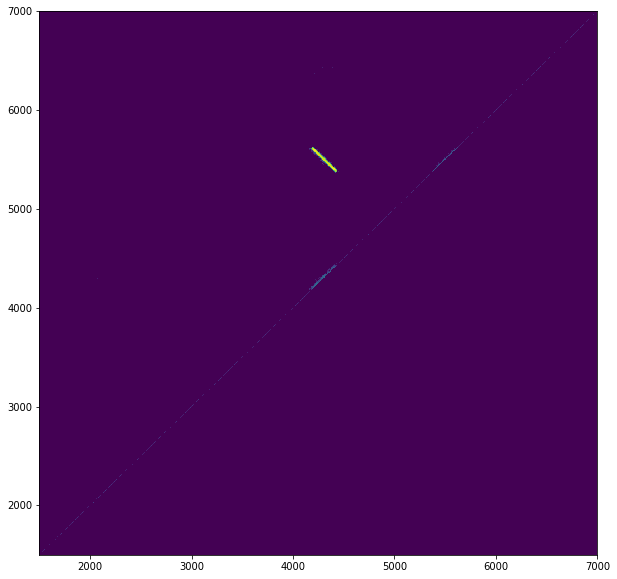

In [8]:
def pipico(tmin,tmax,binN,dataIndexes):
    hist = fh.histogram2d(data.loc[dataIndexes['index2']],data.loc[dataIndexes['index1']],range = [[tmin,tmax],[tmin,tmax]],bins = binN)

    hist = np.log(hist)
    hist[hist == -np.inf] = 0

    print(hist.max())

    dx = (tmax-tmin)/binN

    y, x = np.mgrid[slice(tmin, tmax + dx, dx),
    slice(tmin, tmax + dx, dx)]

    plt.pcolormesh(x,y,hist)
    plt.rcParams["figure.figsize"] = [10,10]
    plt.show()


pipico(1500,7000,1000,pairwise)


In [15]:
compList = pd.DataFrame(np.sort(np.append(cutIndexes['index1'].values,cutIndexes['index2'].values)),columns=['index0']).drop_duplicates().reset_index(drop=True)

Generates a dataframe with a complete list of the indexes of the datafile that were left over after the gating. The momentum and other physics calculations that just involve one particle will be done here, since you can populate the coincidence dataframe later with that info. 

(Man I love Pandas, those one-liners are so nice)

In [16]:
def dataPopulation(data,compList):
        
    temp = data.loc[compList['index0']][['x','y','tof','id','delay']]
    return temp


compList = dataPopulation(data,compList)
#compList['id'] = data.iloc[compList['index0'].values].id.reset_index(drop=True)

print(compList.iloc[:8])

        x      y       tof      id  delay
0  -2.937 -0.085  4422.907  5311.0    0.0
1   2.912  0.725  5405.539  5311.0    0.0
2   2.259  6.385  4425.823  5748.0    0.0
3  -0.806 -4.039  5403.323  5748.0    0.0
4  11.108 -3.324  4228.397  6320.0    0.0
5  -7.369  3.370  5597.941  6320.0    0.0
6 -10.681 -7.402  4208.101  6377.0    0.0
7   9.093  4.886  5598.898  6377.0    0.0


Fills in the data in the Dataframe of the post-cut detections

0.16228478510768213 -0.19755056513616798


<Figure size 720x720 with 0 Axes>

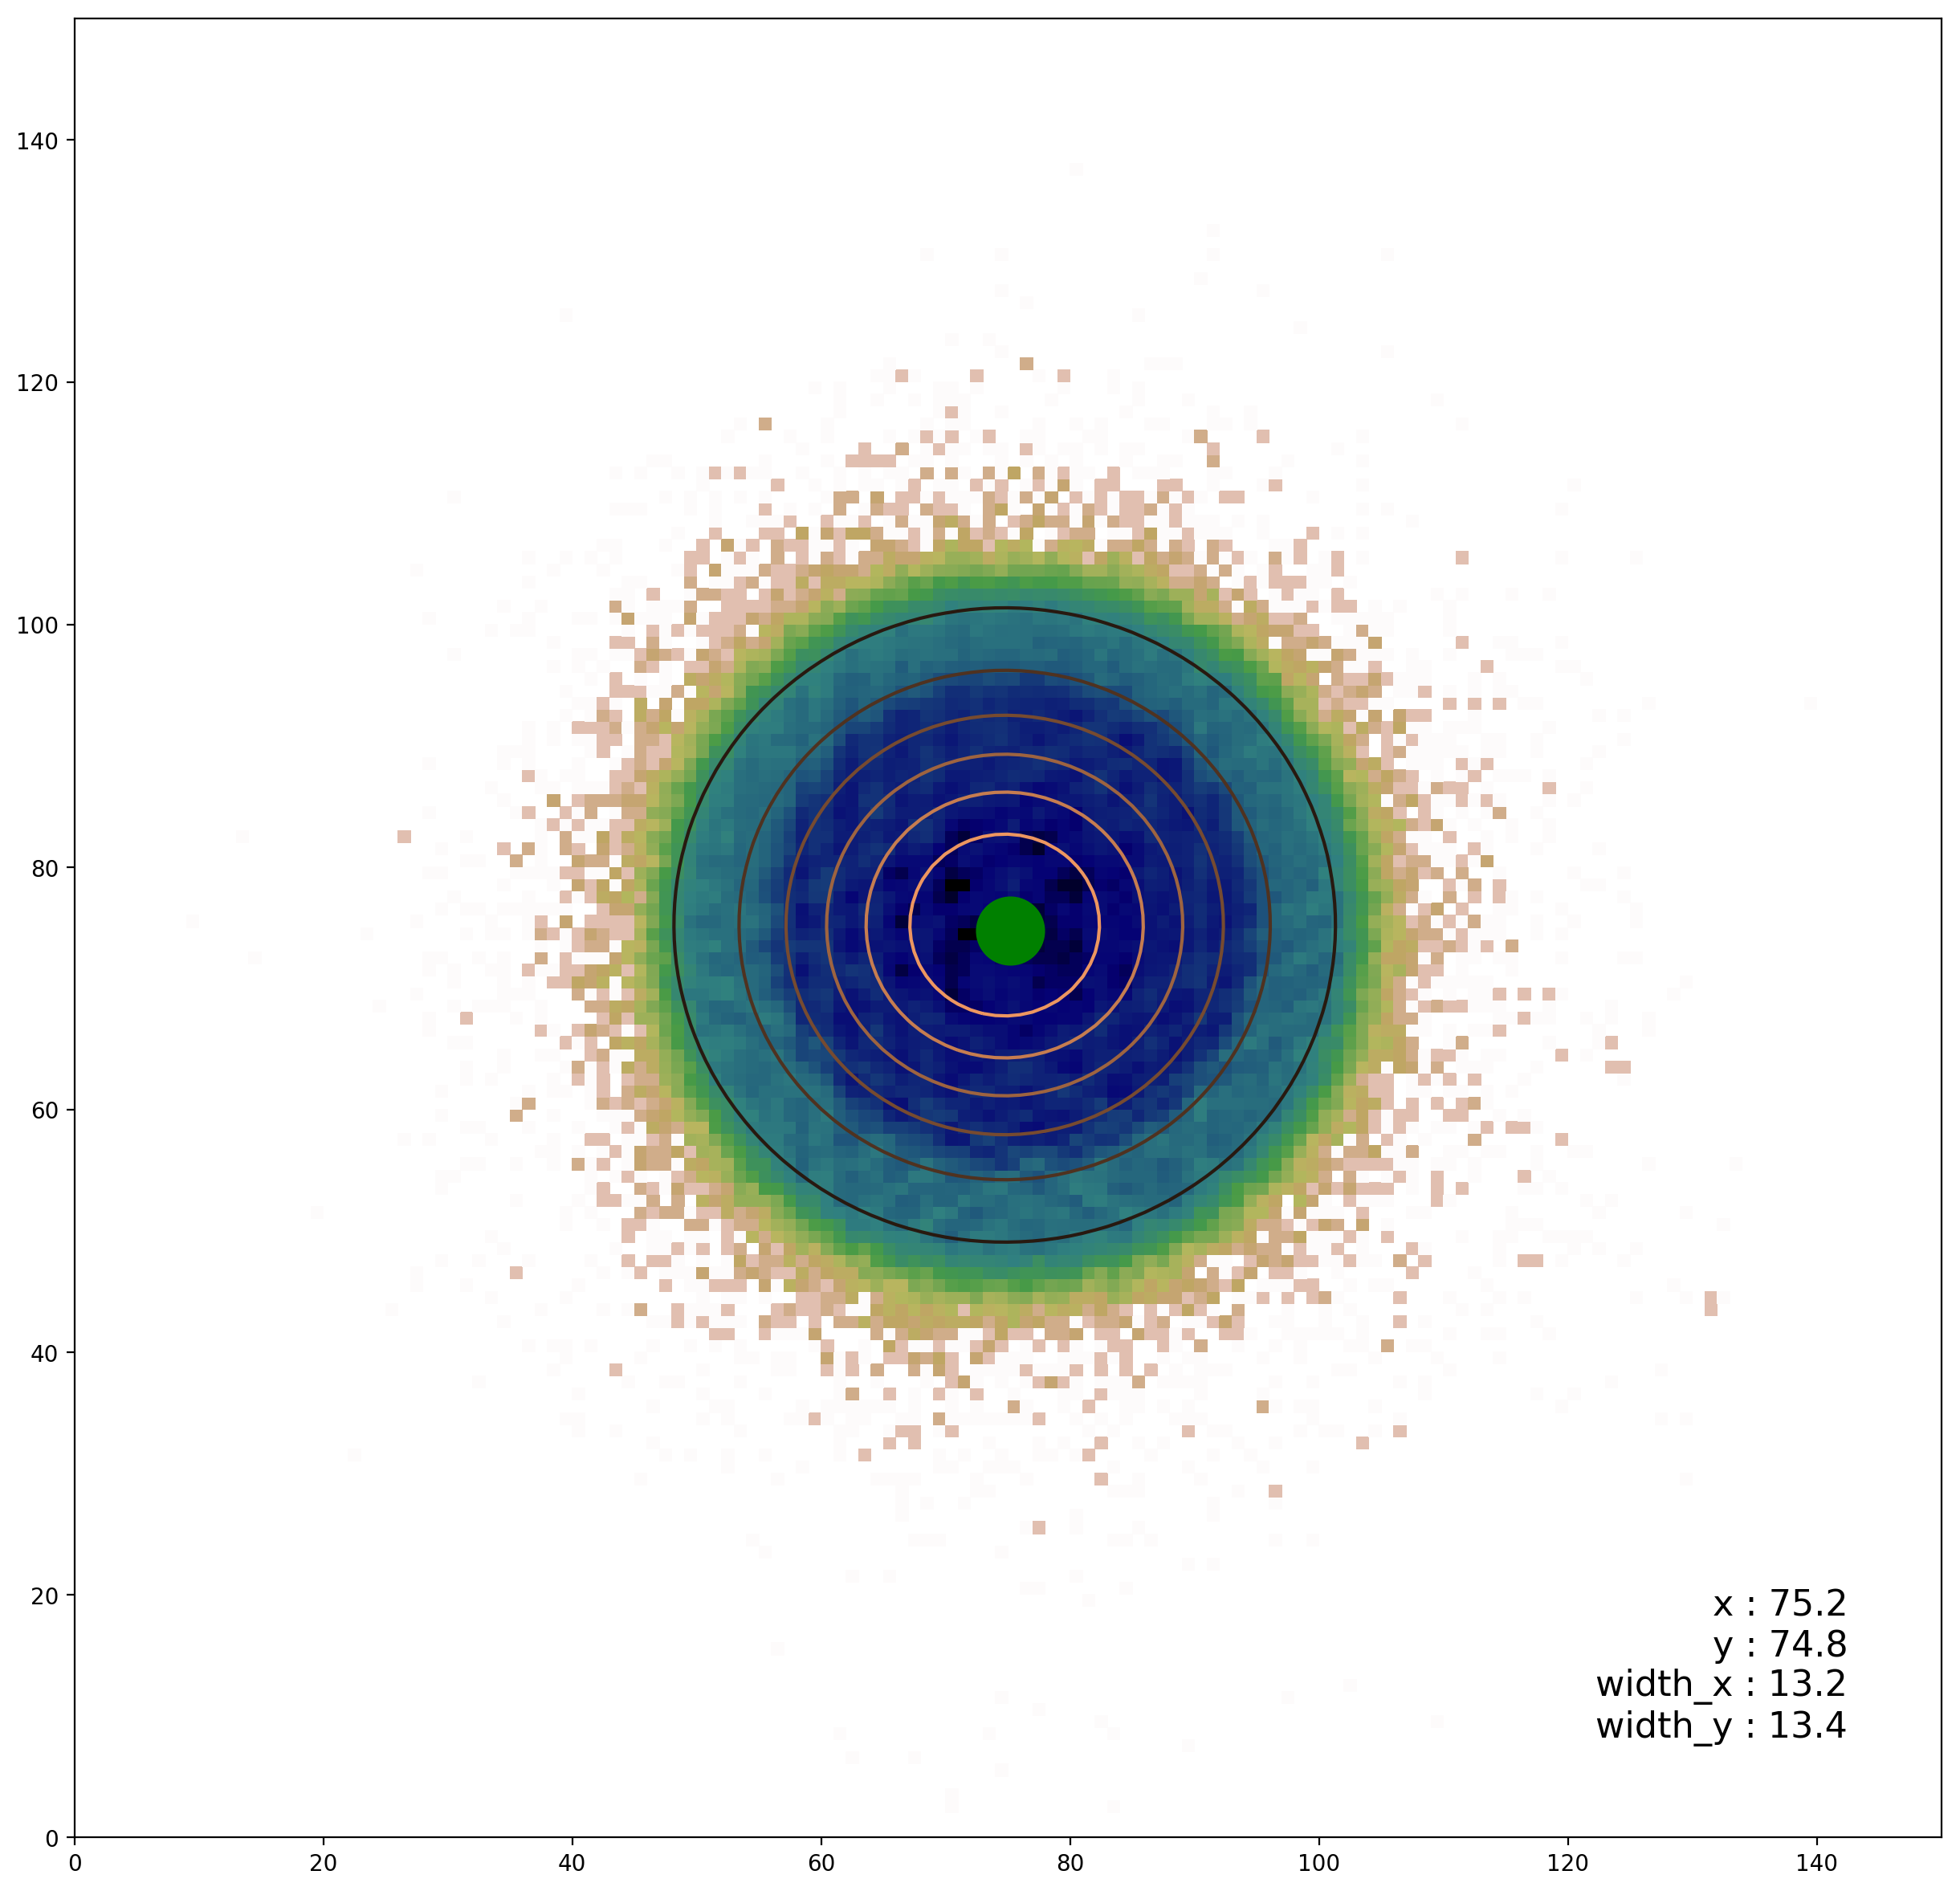

In [17]:
def getCenter(datalist):
    
    from helper import center_by_moments
    
    xmin = -60
    xmax = 60
    xbin = 150

    xy_hist = fh.histogram2d(datalist['x'],datalist['y'],range = [[xmin,xmax],[xmin,xmax]],bins = xbin)

    dx = (xmax- xmin)/xbin

    y_, x_ = np.mgrid[slice(xmin, xmax, dx),
               slice(xmin, xmax, dx)]

    x0,y0 = center_by_moments(x_[0],x_[0],xy_hist,True)
    
    return float(x0),float(y0)

x0, y0 = getCenter(compList)
print(x0,y0)

Gets the center of physics of the cut data.

In [33]:
from helper import fitEfield
from helper import GetZVelocity

E_field_new, ion_drift_length_new, t0_new = fitEfield()

print(ion_drift_length_new)

ion_accel_length = 0.27

#in increasing order of mass (ie, mass of t1, mass of t2, etc)
#and the corisponding charge
mass = [14,27]
mass_si = [(m * 1.66056e-27) for m in mass]
charge = [1,1]

ion_drift_length_new = 0.0118 #modify till 


def apInd(string,ind):
    
    return string+str(ind)


<Parameter 'ion_drift_length', value=0.0149208770918438 +/- 0.36, bounds=[0.013:0.017]>


The above cell sets up calculating the three componants of momenta. It and the two cells below are (I think) generalized for tripico as well.

Change mass and charge as needed. 

In [34]:
def filldata(compList,cutIndexes):
    
    addit = [cutIndexes]
    
    for ind in indList:
        
        temp0 = data.loc[cutIndexes[apInd('index',ind)]][['x','y','tof','delay']].reset_index(drop=True)
        temp0.columns = [apInd(col,ind) for col in temp0]
        addit.append(temp0)
  
    return pd.concat(addit, axis=1)
    

coincXYT = filldata(compList,cutIndexes)

  
print(coincXYT.iloc[:500])


           id  index1  index2      x1      y1      tof1  delay1      x2  \
0      5311.0       0       1  -2.937  -0.085  4422.907   0.000   2.912   
1      5748.0       2       3   2.259   6.385  4425.823   0.000  -0.806   
2      6320.0       4       5  11.108  -3.324  4228.397   0.000  -7.369   
3      6377.0       6       7 -10.681  -7.402  4208.101   0.000   9.093   
4      7842.0       8       9  17.588   2.075  4249.760   0.000 -12.153   
5      8140.0      10      11  12.589   7.283  4363.891   0.000  -8.260   
6     10741.0      12      13  -5.022  -0.279  4405.482   5.173   4.155   
7     12476.0      14      15   9.779   5.518  4412.718   5.173  -5.800   
8     16143.0      16      17  -8.684  -9.080  4388.413   5.173   6.926   
9     16947.0      18      19  -2.076  -2.461  4304.287   5.173  -0.665   
10    19129.0      20      21  -9.672   6.681  4219.538   5.173   8.282   
11    20211.0      22      23  -1.732 -18.423  4287.905   5.163   2.295   
12    20270.0      24    

In [35]:
def velocP(coincXYT):
    
    addit = [coincXYT]
    
    for ind in indList:      
        
        temp = pd.DataFrame()
        
        temp[apInd('tof0',ind)] = coincXYT[apInd('tof',ind)]-t0_new   
     
        temp[apInd('vx',ind)] = (coincXYT[apInd('x',ind)] - (x0+.322)) / (coincXYT[apInd('tof',ind)] - t0_new) * 1000000
        temp[apInd('vy',ind)] = (coincXYT[apInd('y',ind)] - (y0+.319)) / (coincXYT[apInd('tof',ind)] - t0_new) * 1000000
        temp[apInd('vz',ind)] = temp[apInd('tof0',ind)].apply(GetZVelocity,args=(mass[ind-1],charge[ind-1],E_field_new, ion_accel_length ,ion_drift_length_new))    
        
        temp[apInd('px',ind)] = mass_si[ind-1] * temp[apInd('vx',ind)] * 0.5 * 1e24
        temp[apInd('py',ind)] = mass_si[ind-1] * temp[apInd('vy',ind)] * 0.5 * 1e24
        temp[apInd('pz',ind)] = mass_si[ind-1] * temp[apInd('vz',ind)] * 0.5 * 1e24
    
        addit.append(temp)

    return(pd.concat(addit, axis=1))
    

completePop = velocP(coincXYT)

print(completePop.shape)
print(completePop.iloc[:10])

(551619, 25)
        id  index1  index2      x1     y1      tof1  delay1      x2     y2  \
0   5311.0       0       1  -2.937 -0.085  4422.907   0.000   2.912  0.725   
1   5748.0       2       3   2.259  6.385  4425.823   0.000  -0.806 -4.039   
2   6320.0       4       5  11.108 -3.324  4228.397   0.000  -7.369  3.370   
3   6377.0       6       7 -10.681 -7.402  4208.101   0.000   9.093  4.886   
4   7842.0       8       9  17.588  2.075  4249.760   0.000 -12.153 -0.960   
5   8140.0      10      11  12.589  7.283  4363.891   0.000  -8.260 -4.235   
6  10741.0      12      13  -5.022 -0.279  4405.482   5.173   4.155  1.272   
7  12476.0      14      15   9.779  5.518  4412.718   5.173  -5.800 -3.271   
8  16143.0      16      17  -8.684 -9.080  4388.413   5.173   6.926  5.564   
9  16947.0      18      19  -2.076 -2.461  4304.287   5.173  -0.665 -0.442   

       tof2    ...            px1        py1        pz1        tof02  \
0  5405.539    ...     -12.614936  -0.761219 -74.888492 

Populates all three components of velocity, as well as the momentum for every detection selected with the cut, using the masses and charges given above.

In [36]:
completePop['pxsum'] = completePop['px1']+completePop['px2']
completePop['pysum'] = completePop['py1']+completePop['py2']
completePop['pzsum'] = completePop['pz1']+completePop['pz2']

(0.4862703064583164, 14.32345154152121)


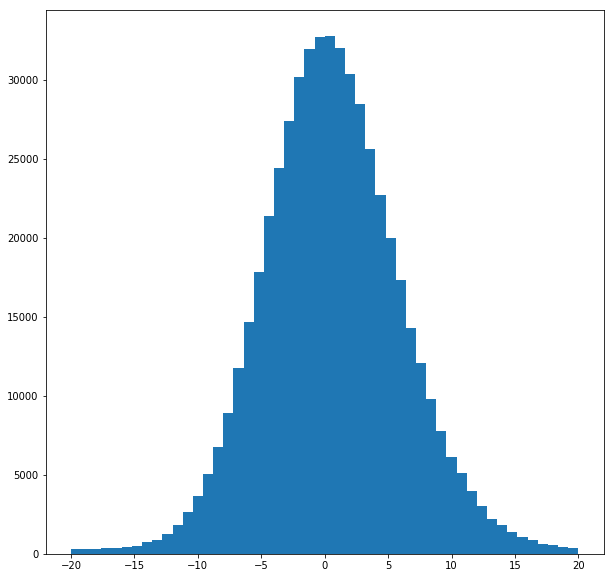

In [37]:
pCur = completePop['pysum']
plt.hist(pCur,bins=50,range=[-20,20])
print(norm.fit(pCur))
plt.show()

In [38]:
plist = [col for col in completePop if col.startswith('p')]
plist_si = [p+'_si' for p in plist]
#print(plist,plist_si)

for p_si in plist_si:
    
    completePop[p_si] = completePop[p_si[:-3]] * 2e-24 


In [40]:
completePop['KE1_ev'] = (completePop['px1_si']**2 + completePop['py1_si']**2 + completePop['pz1_si']**2) /(2*mass_si[0]) *6.242e18
completePop['KE2_ev'] = (completePop['px2_si']**2 + completePop['py2_si']**2 + completePop['pz2_si']**2) /(2*mass_si[1]) *6.242e18

(551619, 39)


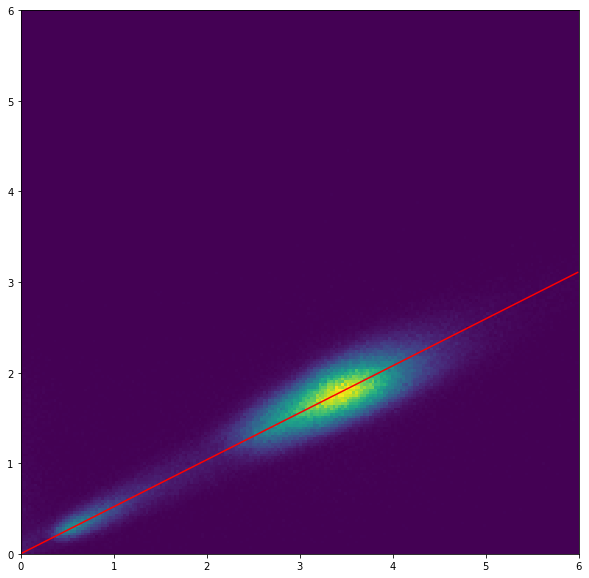

In [41]:
print(completePop.shape)
xx_ = np.arange(0,6,.01)
yy_ = xx_*(mass[0]/mass[1])

plt.hist2d(completePop.KE1_ev,completePop.KE2_ev,bins=200,range=[[0,6],[0,6]])
plt.plot(xx_,yy_,'r')
plt.show()

In [42]:
completePop['KER_ev'] = completePop['KE1_ev'] + completePop['KE2_ev']

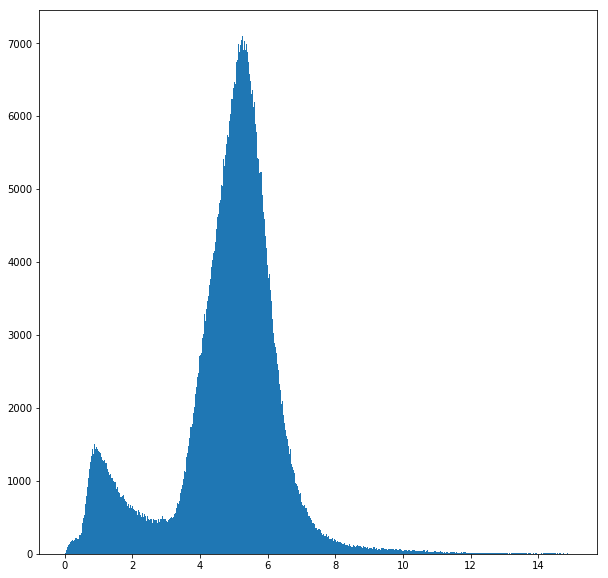

In [43]:
plt.hist(completePop.KER_ev,bins=500,range=[0,15])
plt.show()

In [44]:
completePop['ptot'] = (completePop['pxsum']**2 + completePop['pysum']**2 + completePop['pzsum']**2)**.5

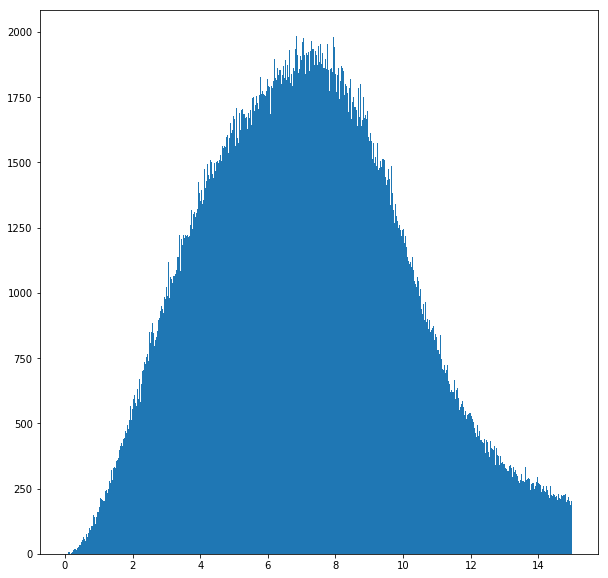

In [45]:
plt.hist(completePop.ptot,bins=500,range=[0,15])
plt.show()

(551619, 41)


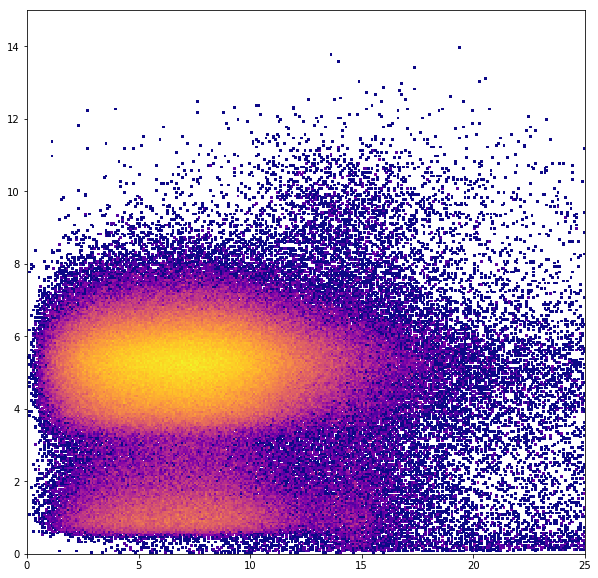

In [48]:
print(completePop.shape)
plt.hist2d(completePop.ptot,completePop.KER_ev,bins=300,norm=mpl.colors.LogNorm(),range=[[0,25],[0,15]],cmap=mpl.cm.plasma)
plt.show()

In [49]:
keCut = completePop[completePop['ptot'] < 23]
print(keCut.shape[0]/completePop.shape[0])

0.9407199534461286


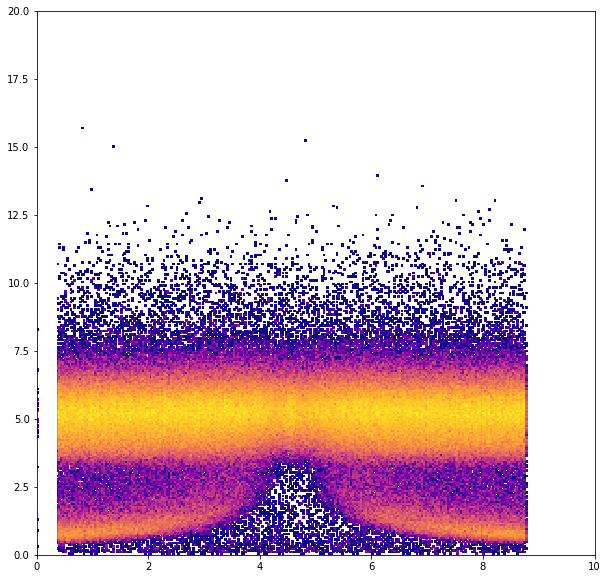

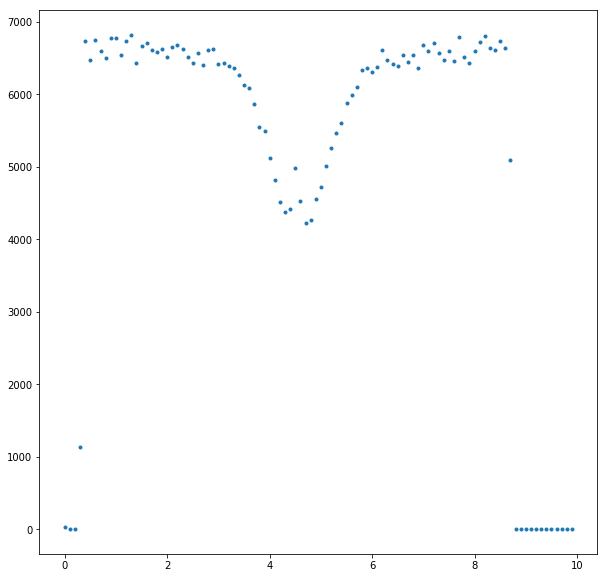

In [57]:
plt.hist2d(keCut.delay1,keCut.KER_ev,bins=300,range= [[0, 10], [0, 20]],norm=mpl.colors.LogNorm(),cmap=mpl.cm.plasma)
plt.show()

hist_ = fh.histogram2d(keCut.KER_ev,keCut.delay1,range= [[0,30],[0,10]],bins = 100)



plt.plot(np.arange(0,10,.1),list(hist_.sum(axis=0)),'.')
plt.show()

In [52]:
kECut = completePop[completePop['KER_ev'] < 3.2]


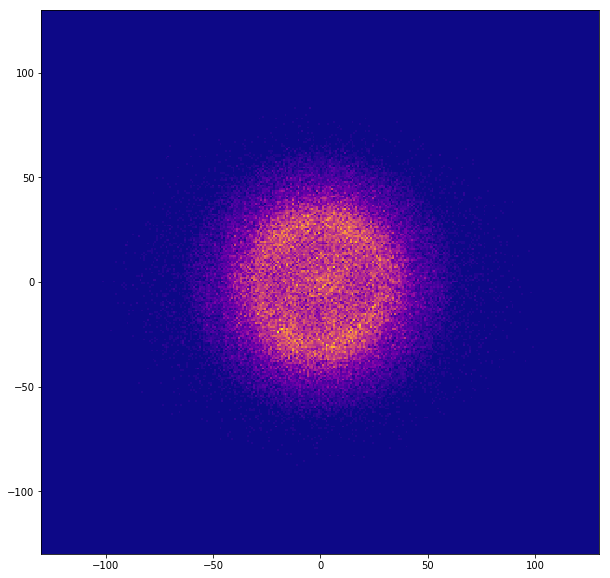

In [53]:
pX = pd.concat([kECut['px1'],kECut['px2']])
pY = pd.concat([kECut['py1'],kECut['py2']])
pZ = pd.concat([kECut['pz1'],kECut['pz2']])


#plt.hist2d(kECut.pz1,kECut.px1+kECut.py1,bins=300,range=[[-100,100],[-140,120]])
plt.hist2d(pX,(pY+pZ)/np.sqrt(2),bins=300,range=[[-130,130],[-130,130]],cmap=mpl.cm.plasma)
plt.show()

In [54]:
from helper import cosineAnglefromMomenta

kECut['cos'] = cosineAnglefromMomenta(kECut['px1'],kECut['py1'],kECut['pz1'],kECut['px2'],kECut['py2'],kECut['pz2'])



/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [55]:
kECut['p2tot'] = (kECut['px2']**2+kECut['py2']**2+kECut['pz2']**2)**.5
kECut['newt_x'] = kECut['cos']*kECut['p2tot']
kECut['newt_y'] = (kECut['p2tot']**2-kECut['newt_x']**2)**.5
print(kECut)

                 id   index1   index2      x1      y1      tof1  delay1  \
9           16947.0       18       19  -2.076  -2.461  4304.287   5.173   
14          23104.0       28       29  -3.469  -3.686  4242.639   5.163   
32          49652.0       64       65  -5.725  -3.760  4351.775   5.121   
56          93220.0      112      113  -8.692  -7.968  4330.130   5.037   
61         101586.0      122      123   8.359   1.286  4284.348   5.011   
117        227835.0      234      235  -2.200  -0.374  4289.947   4.802   
127        239263.0      254      256   0.386   0.051  4313.262   4.786   
141        284356.0      281      282   9.003  -5.237  4274.700   4.701   
183        361204.0      365      366  10.249 -10.883  4287.409   4.559   
189        372743.0      377      378  -0.105  11.855  4312.158   4.543   
283        537063.0      564      565  -9.572  12.877  4293.662   4.257   
324        630455.0      646      647  -5.964  -3.470  4324.041   4.080   
379        748484.0      

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

In [56]:
import matplotlib.animation as animation
from IPython.display import HTML

step_n = 5
max_delay = 1300

step_size = (8.776-4.6)/step_n
delay_step= max_delay/step_n

def newt_getslice(n):

    cent = 4.6
    maxi = 8.778 

    lowp = cent+ step_size*n
    higp = cent+ step_size*(n+1)
    
    lowm = cent- step_size*n
    higm = cent- step_size*(n+1)
    
    x = pd.concat([kECut['newt_x'][(kECut['delay1']> lowp)&(kECut['delay1']<higp)],kECut['newt_x'][(kECut['delay1']> higm)&(kECut['delay1']<lowm)]])
    y = pd.concat([kECut['newt_y'][(kECut['delay1']> lowp)&(kECut['delay1']<higp)],kECut['newt_y'][(kECut['delay1']> higm)&(kECut['delay1']<lowm)]])

    plt.hist2d(x,y,bins=300,cmap=mpl.cm.plasma,norm=mpl.colors.LogNorm(),range=[[-90,90],[0,100]])
    plt.title(str(int(delay_step*n))+' to '+str(int(delay_step*(n+1)))+' fs')
    plt.ylabel('Momentum (AU)')
    plt.xlabel('Momentum (AU)')
    plt.savefig('tmp'+str(n)+'.png')
    plt.close()

for i in range(step_n):
    
    newt_getslice(i)
